# Description

This notebook is intended to test FEM capabilities using libigl bound to python.

# Load libraries

In [1]:
import igl
import scipy as sp
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt
import time
from IPython import display

shadingOptions = {
    "flat":True,
    "wireframe":True,
}

# Initial parameters

## Initial mesh

In [2]:
# Read mesh and retrieve shape
v, t = igl.read_msh("../meshes/ball.msh")
print("===== Characteristics of the mesh =====")
print("Number of vertices: {}".format(v.shape[0]))
print("Number of tetrahedrons: {}".format(t.shape[0]))

# Rubber characteristics
rho     = 1.522 # [kg.m-3]
young   = 0.1e9 # [Pa]
poisson = 0.4   # [no unit]

# Visualize
mp.plot(v, t, shading=shadingOptions)

===== Characteristics of the mesh =====
Number of vertices: 198
Number of tetrahedrons: 636


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0020764…

In [3]:
from ElasticObject import ElasticObject

eo = ElasticObject(v, t, rho, young, poisson)

# Basis functions

## Definition

In [4]:
def inTriangle(X, Xtri):
    '''
    Input:
    - X    : position of the point for which we test belonging
    - Xtri : position of the triangle's vertices, row by row
    
    Output:
    - isInside : whether the point belongs to the triangle or not
    '''
    abg      = np.linalg.solve(Xtri.T, X)
    isInside = (abs(np.sum(abg) - 1) < 1e-9) and (0. <= abg <= 1.)
    return isInside

def inTet(X, Xtet):
    '''
    Input:
    - X    : position of the point for which we test belonging
    - Xtet : position of the tetrahedron's vertices, row by row
    
    Output:
    - isInside : whether the point is inside the tet or not
    '''
    abg      = np.linalg.solve(Xtet[:3, :] - Xtet[3, :], X - Xtet[3, :])
    isInside = (np.sum(abg) <= 1) and (0. <= abg <= 1.)
    return isInside

def basisEvalTri(v, f, X, v_id, f_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - f    : indices of the element's vertices (nE, 3)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - f_id : face id of the 
    
    Output:
    - val : value of the basis function at X
    '''
    # Permute indices so that the first row in Xtri (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed area
    nPerm   = np.argwhere(f[f_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%f.shape[1] for i in range(f.shape[1])]
    
    # Select with permutation
    Xtri    = v[f[f_id]][idxPerm, :]
    
    # Compute gradients
    dirOrt  = (Xtri[1, :] - Xtri[2, :]) / np.linalg.norm(Xtri[1, :] - Xtri[2, :])
    gradDir = (Xtri[0, :] - Xtri[1, :]) - dirOrt @ (Xtri[0, :] - Xtri[1, :]) * dirOrt
    grad    = gradDir / (gradDir @ (Xtri[0, :] - Xtri[1, :]))
    
    # Compute value:
    val = grad @ (X - Xtri[1, :])
    
    return val

def basisEvalTet(v, t, X, v_id, t_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - t    : indices of the element's vertices (nE, 4)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - t_id : face id of the tetrahedron
    
    Output:
    - val : value of the basis function at X
    '''
    # Permute indices so that the first row in Xtet (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed volume
    nPerm   = np.argwhere(t[t_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%t.shape[1] for i in range(t.shape[1])]
    
    # Select with permutation
    Xtet    = v[t[t_id]][idxPerm, :]
    
    # Compute gradients
    gradDir = np.cross(Xtet[2, :] - Xtet[1, :], Xtet[3, :] - Xtet[1, :])
    grad    = gradDir / (gradDir @ (Xtet[0, :] - Xtet[1, :]))
    
    # Compute value:
    val = grad @ (X - Xtet[1, :])
    
    return val

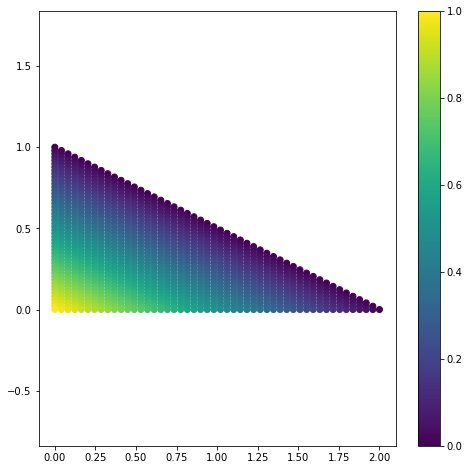

In [5]:
testV = np.array([[0., 0., 0.],
                  [0., 1., 0.],
                  [2., 0., 0.]])

testF = np.array([[0, 1, 2]])

# Barycentric coordinates
as_, bs_ = np.linspace(0, 1), np.linspace(0, 1)

abgs = []
for a in as_:
    for b in bs_:
        g = 1. - a - b
        if g >= 0:
            abgs.append([a, b, g])
                
ABGs = np.array(abgs)

# Points coordinates
pointsPlot = ABGs @ testV[testF[0]]

# Compute basis function value
vals = np.zeros(shape=pointsPlot.shape[0])
for i, point in enumerate(pointsPlot):
    vals[i] = basisEvalTri(testV, testF, point, 0, 0)

plt.figure(figsize=(8, 8))
sc = plt.scatter(pointsPlot[:, 0], pointsPlot[:, 1], c=vals)
plt.colorbar(sc)
plt.axis('equal')
plt.show()

## Gradients

In [ ]:
def basisGradEvalTri(v, f, X, v_id, f_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - f    : indices of the element's vertices (nE, 3)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - f_id : face id of the 
    
    Output:
    - grad : value of the gradient of the basis function at X
    '''
    # Permute indices so that the first row in Xtri (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed area
    nPerm   = np.argwhere(f[f_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%f.shape[1] for i in range(f.shape[1])]
    
    # Select with permutation
    Xtri    = v[f[f_id]][idxPerm, :]
    
    # Compute gradients
    dirOrt  = (Xtri[1, :] - Xtri[2, :]) / np.linalg.norm(Xtri[1, :] - Xtri[2, :])
    gradDir = (Xtri[0, :] - Xtri[1, :]) - dirOrt @ (Xtri[0, :] - Xtri[1, :]) * dirOrt
    grad    = gradDir / (gradDir @ (Xtri[0, :] - Xtri[1, :]) + 1e-5)
    
    return grad

def basisGradEvalTet(v, t, X, v_id, t_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - t    : indices of the element's vertices (nE, 4)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - t_id : tet id
    
    Output:
    - grad : value of the gradient of the basis function at X
    '''
    # Permute indices so that the first row in Xtet (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed volume
    nPerm   = np.argwhere(t[t_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%t.shape[1] for i in range(t.shape[1])]
    
    # Select with permutation
    Xtet    = v[t[t_id]][idxPerm, :]
    
    # Compute gradients
    gradDir = np.cross(Xtet[2, :] - Xtet[1, :], Xtet[3, :] - Xtet[1, :])
    grad    = gradDir / (gradDir @ (Xtet[0, :] - Xtet[1, :]))
    
    return grad

# Explicit time integration

## Precomputation

In [8]:
from elasticsolid2 import ElasticSolid
from elasticenergy import *

In [10]:
rho     = 100  # [kg.m-3] 10000kg.m-3 to see gravity effects
damping = 0.
young   = 1e6 # [Pa] 
poisson = 0.2
dt      = 1e-4

ee = LinearElasticEnergy(young, poisson)

es = ElasticSolid(v, t, ee, rho=rho, damping=damping, 
                  pin_idx=[], f_ext=None, self_weight=False)

v_def = v.copy()
v_def[:, 2] *= 1.5 
es.update_shape(v_def)

In [11]:
iterations = 10
for i in range(iterations):
    es.equilibrium_step()

2588.4389114316837
Residuals: 11130.066568824453


AssertionError: 

In [ ]:
eo.Precomputation()
print("Proportion of positive volumes: {:.2f}".format(np.mean(eo.initVols > 0)))

## Elastic Forces

In [ ]:
randPert = 0.02 * np.random.uniform(low=-1., high=1., size=v.shape)
forces = eo.ComputeElasticForces(v + randPert)

p = mp.plot(v + randPert, t, shading=shadingOptions)
p.add_lines(v + randPert, v + randPert + 1e-7*forces)

## Explicit time integration

In [ ]:
# %%capture

randPert = 0.04 * np.random.uniform(low=-1., high=1., size=v.shape)
initPert = np.zeros_like(v)
initPert[110, 1] = 0.1
nSteps   = 10
dt       = 1e-6

# vTmp    = v + randPert
vTmp    = v + initPert
velTmp  = np.zeros(shape=vTmp.shape)

for step in range(nSteps):
    display.clear_output(wait=True)
    forces  = eo.ComputeElasticForces(vTmp)
    massTmp = np.diag(eo.ComputeMassMatrix(vTmp, lumped=True))
    velTmp += dt * np.diag(1 / (rho * massTmp)) @ forces # only works for diagonal matrices
    vTmp   += dt * velTmp
    p = mp.plot(vTmp, t, shading=shadingOptions)
#     p.save("output/explicitSphere/step{}".format(step))
    time.sleep(0.001)

# Implicit time integration

## Mass matrix computation

In [ ]:
mass = eo.ComputeMassMatrix(v, lumped=True)
mass[:5, :5]

## Force differential

In [ ]:
initPert = np.zeros_like(v)
initPert[110, 1] = 0.1

dForces = eo.ComputeForceDifferentials(v + initPert, initPert)
print(dForces.shape)

## Conjugate Gradient

In [ ]:
def ConjugateGradient(AxMethod, b, x0=None, eps=1e-9, maxSteps=None):
    '''
    We intend to solve Ax = b where A is positive definite.
    A has shape (dim, dim), x and b have shape (dim, n).
    
    
    Input:
    - AxMethod : a method that takes x and returns the product Ax
    - b        : right hand side of the linear system
    - x0       : initial guess for x0 (defaults to 0s)
    - eps      : tolerance on the residual magnitude
    - maxSteps : maximum number of steps one wants to run (defaults to dim)
    
    Output:
    - xStar : np array of shape (dim, n) solving the linear system
    '''
    
    dim, n = b.shape
    if maxSteps is None:
        maxSteps = dim
        
    if x0 is None:
        xStar = np.zeros_like(b)
    else:
        xStar = x0
        
    residuals  = b - AxMethod(xStar)
    directions = residuals
    
    # Reusable quantities
    A_directions = AxMethod(directions) # A p
    resNormsSq   = np.sum(residuals**2, axis=0) # r^T r
    dirNormsSqA  = np.zeros(shape=(n,)) # stores p^T A p
    for i in range(n):
        dirNormsSqA[i] = directions[:, i] @ A_directions[:, i]
    
    for k in range(maxSteps):

        alphas     = resNormsSq / dirNormsSqA

        xStar     = xStar + directions * alphas
        residuals = residuals - A_directions * alphas
        
        newResNormsSq = np.sum(residuals**2, axis=0)
        if max(np.sqrt(newResNormsSq)) < eps:
            # Stop if tolerance is satisfied
            break
            
        betas      = newResNormsSq / resNormsSq
        directions = residuals + directions * betas
        A_directions = AxMethod(directions)
        resNormsSq   = newResNormsSq
        for i in range(n):
            dirNormsSqA[i] = directions[:, i] @ A_directions[:, i]
        
    return xStar

### Testing on a simple case

In [ ]:
from scipy.sparse.linalg import cg, eigsh, LinearOperator

randMat = np.random.rand(3, 3)
A = randMat @ randMat.T + 1e-3 * np.eye(randMat.shape[0]) # Make it positive definite
w = eigsh(A, return_eigenvectors=False)
print("Number of non positive eigenvalues: {}\n".format(sum(w<=0)))
b = np.random.rand(3, 1)

AxMethod = lambda x: A @ x
LOp = LinearOperator(A.shape, AxMethod)

solScipy, info = cg(LOp, b)
print("==== Solution found by scipy ====")
print("Residual norm: {:.3f}".format(np.linalg.norm(A @ solScipy.reshape(-1, b.shape[1]) - b)))
print("The solution is: {}\n".format(solScipy))

sol = ConjugateGradient(AxMethod, b, x0=None, eps=1e-9, maxSteps=None)
print("==== Solution found by homemade method ====")
print("Residual norm: {:.3f}".format(np.linalg.norm(A @ sol - b)))
print("The solution is: {}".format(sol))

## Implicit time integration

In [ ]:
# %%capture

randPert  = 0.04 * np.random.uniform(low=-1., high=1., size=v.shape)
initPert = np.zeros_like(v)
initPert[110, 1] = 0.1
nSteps    = 50
nSubsteps = 2
dt        = 3e-6  # [s]
gamma     = 0     # should be turned off, this doesn't work yet [s]

# vTmp    = v + randPert
vTmp    = v + initPert
velTmp  = np.zeros(shape=vTmp.shape)

velTmpCorrection = velTmp
vTmpCorrection   = vTmp
deltaV = np.zeros_like(vTmp)

for step in range(nSteps):
    display.clear_output(wait=True)
    for substep in range(nSubsteps):
        # Mass matrix
        massTmp = eo.rho * eo.ComputeMassMatrix(vTmp, lumped=True)
        # Damping 
        dForces = - gamma * eo.ComputeForceDifferentials(vTmpCorrection, velTmpCorrection)
        #Elastic
        eForces  = eo.ComputeElasticForces(vTmpCorrection)
        #Total
        totForces = eForces + dForces
        
        #Invert system
        LHSMethod = lambda dV : (1/dt**2 * massTmp @ dV + (1 + gamma/dt) * eo.ComputeForceDifferentials(vTmpCorrection, dV))
        RHS    = 1/dt * massTmp @ (velTmp - velTmpCorrection) + totForces
        deltaV = ConjugateGradient(LHSMethod, RHS, x0=None, maxSteps=None, eps=1e-3)
        
        #Update position and velocities
        vTmpCorrection   += deltaV
        velTmpCorrection += deltaV / dt
    
    #Update position and velocities, then start a new time step
    vTmp   = vTmpCorrection
    velTmp = velTmpCorrection
    
    p = mp.plot(vTmp, t, shading=shadingOptions)
#     p.save("output/explicitSphere/step{}".format(step))
    time.sleep(0.02)

In [26]:
import numpy as np

idx = []
A = np.random.rand(5, 2, 2)
print(A)
A[idx]

[[[0.40192122 0.9500353 ]
  [0.08255861 0.12160871]]

 [[0.58102831 0.02067545]
  [0.64532783 0.33682197]]

 [[0.3894157  0.06040827]
  [0.11905393 0.26344311]]

 [[0.59901969 0.7699008 ]
  [0.47341399 0.8364525 ]]

 [[0.43206536 0.40839731]
  [0.882466   0.85246149]]]


array([], shape=(0, 2, 2), dtype=float64)

In [27]:
A[idx] = 0
print(A)

[[[0.40192122 0.9500353 ]
  [0.08255861 0.12160871]]

 [[0.58102831 0.02067545]
  [0.64532783 0.33682197]]

 [[0.3894157  0.06040827]
  [0.11905393 0.26344311]]

 [[0.59901969 0.7699008 ]
  [0.47341399 0.8364525 ]]

 [[0.43206536 0.40839731]
  [0.882466   0.85246149]]]


In [32]:
A = np.random.rand(5)
np.argwhere(A<0.5)

array([[0],
       [1]])

In [33]:
np.arange(A.shape[0])[A<0.5]

array([0, 1])

In [34]:
F = np.array([
    [1, 0, 1],
    [0, 2, 0],
    [0, 0, 3]
])

In [35]:
0.5 * (F.T @ F - np.eye(3))

array([[0. , 0. , 0.5],
       [0. , 1.5, 0. ],
       [0.5, 0. , 4.5]])

In [38]:
from scipy.linalg import polar
R, S = polar(F)

In [39]:
S @ S

array([[ 1.,  0.,  1.],
       [ 0.,  4.,  0.],
       [ 1.,  0., 10.]])

In [40]:
S

array([[0.9701425 , 0.        , 0.24253563],
       [0.        , 2.        , 0.        ],
       [0.24253563, 0.        , 3.15296313]])

In [43]:
np.linalg.inv(F)

array([[ 1.        ,  0.        , -0.33333333],
       [ 0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.        ,  0.33333333]])